In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import numpy as np
import torch
import torch.nn as nn
import utils.checkpoint as cu
import utils.distributed as du
import utils.logging as logging
import utils.misc as misc
from datasets import loader
from models import model_builder

In [2]:
logger = logging.get_logger(__name__)
TARGET_DIR = "./results/kstartv_i3d_nln_16_8_2_224"
import multiprocessing as mp
def upsample(in_img, in_scale_factor= (2,32,32)):
    upsample = nn.Upsample( scale_factor = in_scale_factor, mode = "bilinear")

In [3]:
def cam_view_test(test_loader, model, cfg):
    model.eval()
    
    for cur_iter, (inputs, labels, video_idx) in enumerate(test_loader):
        if isinstance(inputs, (list,)):
            for i in range(len(inputs)):
                inputs[i] = inputs[i].cuda(non_blocking=True)
        else:
            inputs = inputs.cuda(non_blocking=True)
        labels = labels.cuda()
        video_idx = video_idx.cuda()
        # preds : (8, 2, 1, 1, 1)
        # feat : (8, 2048, 4, 7, 7)
        # fc_w : (2, 2048)
        preds,feat,fc_w = model(inputs)
        preds = torch.squeeze(preds)
        preds_idx = torch.argmax(preds, dim=1)
        # fc_w_wide : (8, 2048 )
        fc_w_wide = fc_w[preds_idx] 
        # feat : (8, 2048, 4, 7, 7)
        # feat_per : (8, 4, 7, 7, 2048)
        feat_per = feat.permute((0,2,3,4,1))
        # ouput : ( 4, 7, 7, 2048) * (2048) = (4,7,7)
        output = torch.matmul(feat_per[0],fc_w_wide[0])
        
        upsample2=nn.Upsample(scale_factor = (2,1,1), mode = 'trilinear')
        output_unsqz =torch.unsqueeze(output,0) 
        output_unsqz =torch.unsqueeze(output_unsqz,0)
        print(output_unsqz.shape)
        up_img_temp = upsample2(output_unsqz)
        # up_img_temp : (8,7,7)
        #up_img_temp = upsample2(output)
        print(up_img_temp.shape)

        upsample=nn.Upsample(scale_factor = (32,32), mode = 'bilinear')
        up_img_temp_sqz = torch.squeeze(up_img_temp,0)
        print(up_img_temp_sqz.shape)
        up_img = upsample(up_img_temp_sqz)
        print(up_img.shape)
        up_img = torch.squeeze(up_img,0)
        print(up_img.shape)
        #return up_img

In [4]:
def cam_test(cfg):
    np.random.seed(cfg.RNG_SEED)
    torch.manual_seed(cfg.RNG_SEED)
    logging.setup_logging()
    #cfg.BATCH_SIZE = 1
    logger.info("run with config:")
    logger.info(cfg)

    model = model_builder.build_model(cfg)
    misc.log_model_info(model)
    if cu.has_checkpoint(TARGET_DIR):
        last_checkpoint = cu.get_last_checkpoint(TARGET_DIR)
        cu.load_checkpoint(last_checkpoint, model, cfg.NUM_GPUS > 1)
    else:
        raise NotImplementedError("Unknown way to load checkpoint.")

    test_loader = loader.construct_loader(cfg, "test")
    logger.info("Testing model for {} iterations".format(len(test_loader)))

    assert(
        len(test_loader.dataset)
        % (cfg.TEST.NUM_ENSEMBLE_VIEWS * cfg.TEST.NUM_SPATIAL_CROPS)
        == 0
    )
    cam_img = cam_view_test(test_loader, model,  cfg)

In [13]:
#!/usr/bin/env python3
import argparse
import sys
import torch

import utils.checkpoint as cu
import utils.multiprocessing as mpu
from config.defaults import get_cfg

from test_net import test
from train_net import train


def parse_args():
    parser = argparse.ArgumentParser(
        description="Provide NonLocalI3D img training and testing pipline. "
    )
    parser.add_argument(
        "--share_id",
        help="The shard id of current node, Starts from 0 to num_shareds - 1",
        default=0,
        type=int,
    )
    parser.add_argument(
        "--num_shards",
        help="Number of shards using by the job",
        default=1,
        type=int,
    )
    parser.add_argument(
        "--init_method",
        help="Initialization method, includes TCP or shared file-system",
        default="tcp://localhost:9999",
        type=str,
    )
    parser.add_argument(
        "--cfg",
        dest="cfg_file",
        help="Path to the config file",
        default=None,
        type=str,
    )
    parser.add_argument(
        "opts",
        help="See config/defaults.py for all options",
        default=None,
        nargs=argparse.REMAINDER,
    )
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)
    return parser.parse_args()

def load_config(args):
    cfg = get_cfg()
    if args.cfg_file is not None:
        cfg.merge_from_file(args.cfg_file)

    if args.opts is not None:
        cfg.merge_from_list(args.opts)

    if hasattr(args, "num_shards") and hasattr(args,"shard_id"):
        cfg.NUM_SHARDS = args.num_shards
        cfg.SHARD_ID = args.shard_id
    if hasattr(args,"rng_seed"):
        cfg.RNG_SEED = args.rng_seed
    if hasattr(args, "output_dir"):
        cfg.OUTPUT_DIR = args.output_dir
    
    cu.make_checkpoint_dir(cfg.OUTPUT_DIR)
    return cfg

def main():
    #args = parse_args()
    #cfg  = load_config(args)
    cfg = get_cfg()
    cfg.merge_from_file('config/configs/kstartv/I3D_NLN_8x8_R50_KSTARTV.yaml')
    cfg.BATCH_SIZE = 8
    cfg.NUM_GPUS = 2
    cu.make_checkpoint_dir(cfg.OUTPUT_DIR)

    if cfg.TEST.ENABLE:
        if cfg.NUM_GPUS > 1:
            torch.multiprocessing.spawn(
                mpu.run,
                nprocs=cfg.NUM_GPUS,
                args=(
                    cfg.NUM_GPUS,
                    cam_test,
                    "tcp://localhost:9999",
                    cfg.SHARD_ID,
                    cfg.NUM_SHARDS,
                    cfg.DIST_BACKEND,
                    cfg,
                ),
                daemon=False,
            )

        else:
            cam_test(cfg=cfg)

if __name__=="__main__":

    main()

Exception: process 0 terminated with exit code 1

[0]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00036.jpg
1
[1]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00037.jpg
2
[2]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00038.jpg
3
[3]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00039.jpg
4
[4]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00040.jpg
5
[5]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00041.jpg
6
[6]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00042.jpg
7
[7]: /data/KSTAR_TV_DATASET/dataset/019989/019989-00043.jpg
8
img_show


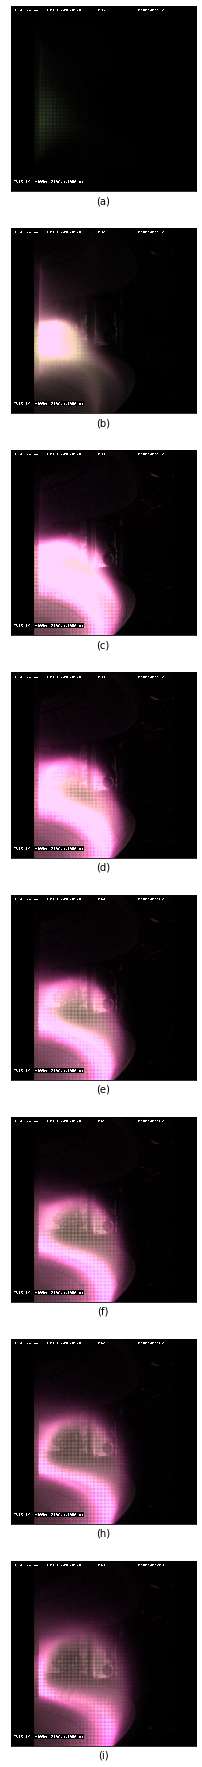

In [4]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [32, 32]
rows=8
cols=1
img_dir_path = '/data/KSTAR_TV_DATASET/dataset/019989'
xlabels = ["xlabel", "(a)","(b)","(c)","(d)","(e)","(f)","(h)","(i)"]

img_file_lst = np.sort(os.listdir(img_dir_path))

for idx, f_name in enumerate(img_file_lst):
    img_path = os.path.join(img_dir_path,f_name)
    print("[{}]: {}".format(idx,img_path))
    img = cv2.imread(img_path)
    cv2.imshow('img',img)
    xlab_idx = idx % 8 +1
    ax = fig.add_subplot(rows, cols, xlab_idx)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    print(xlab_idx)
    ax.set_xlabel(xlabels[xlab_idx])
    ax.set_xticks([]), ax.set_yticks([])
    if(idx % 8 ==7 ):
        #print(idx)
        print("img_show")
    
        

        break
plt.show()